<a href="https://colab.research.google.com/github/heroza/Experiment-0/blob/main/ISIC%20Classification%20with%209%20classes%20using%20Inception-V3%20TL%20with%20Fine%20Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 777M/786M [00:08<00:00, 117MB/s] 
100% 786M/786M [00:08<00:00, 96.0MB/s]


In [2]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [3]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [5]:
len(df.index)

2239

In [6]:
df.head(3)

,FilePaths,Labels
0,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma
1,/content/Skin cancer ISIC The International Sk...,melanoma
2,/content/Skin cancer ISIC The International Sk...,vascular lesion


Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

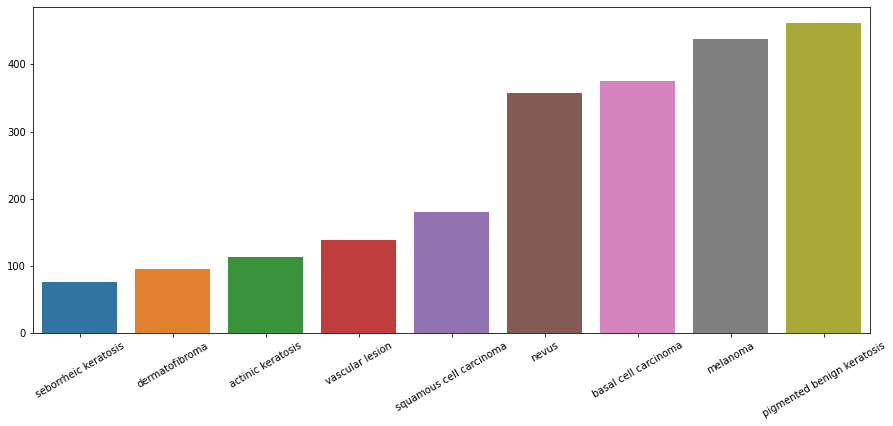

In [7]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

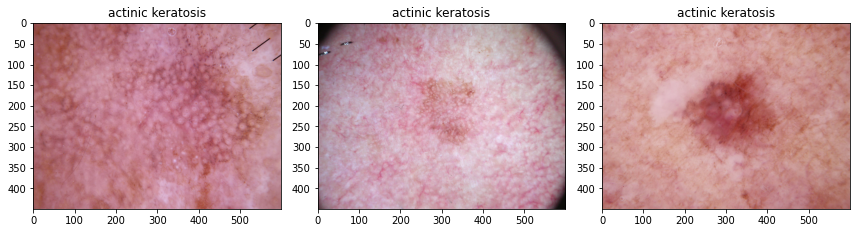

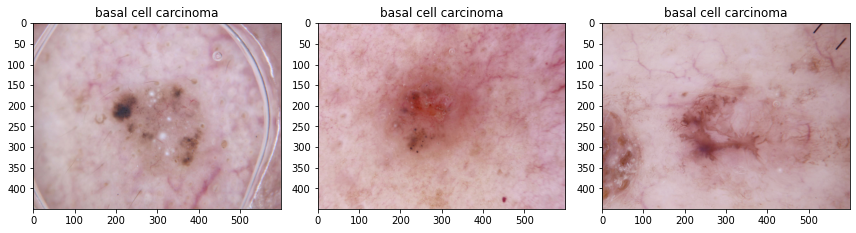

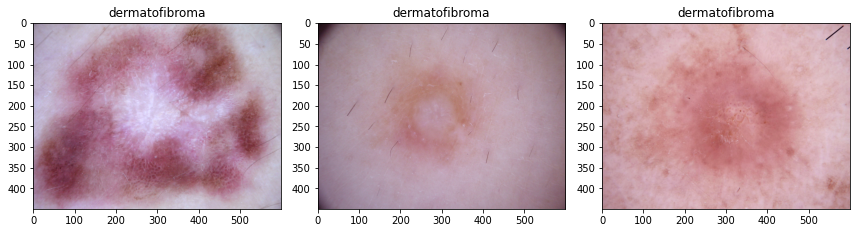

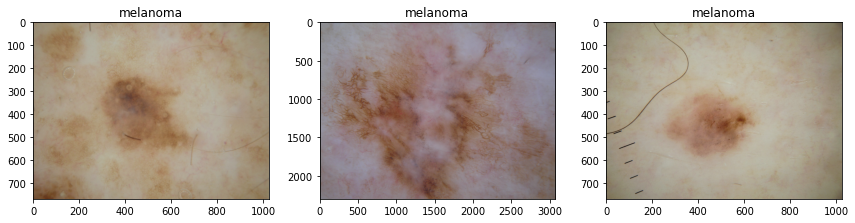

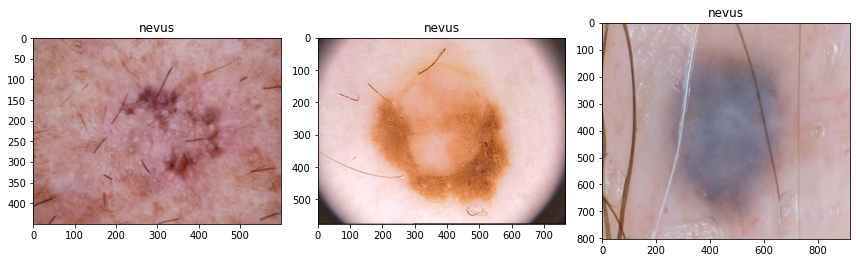

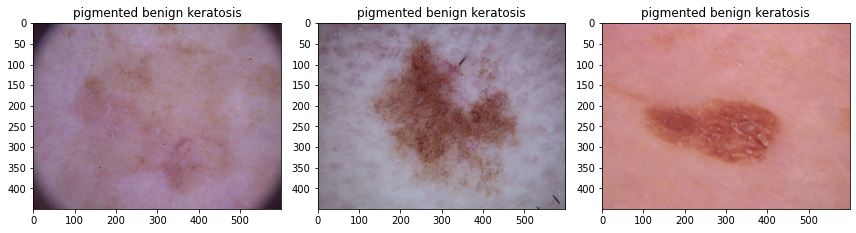

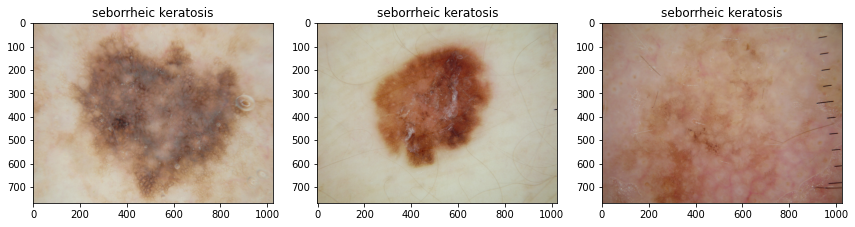

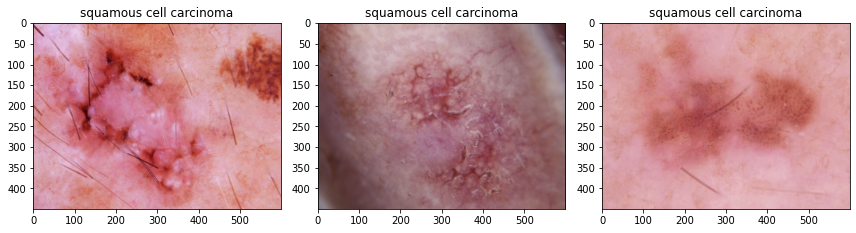

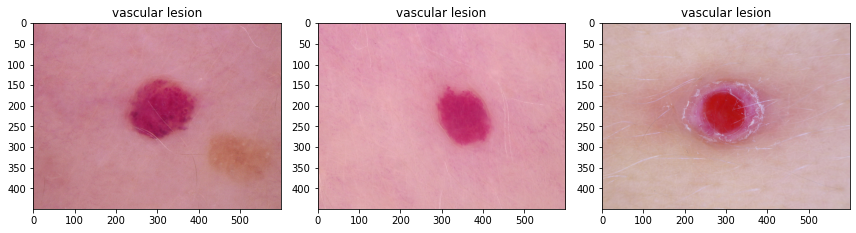

In [9]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

Split dataset to train and val

In [10]:
from sklearn.model_selection import train_test_split
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1791, 2)
Val Data:  (448, 2)


Data Augmentation

In [11]:
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

In [12]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224,224) #use AlexNet inpu size instead (224, 224)

In [13]:
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

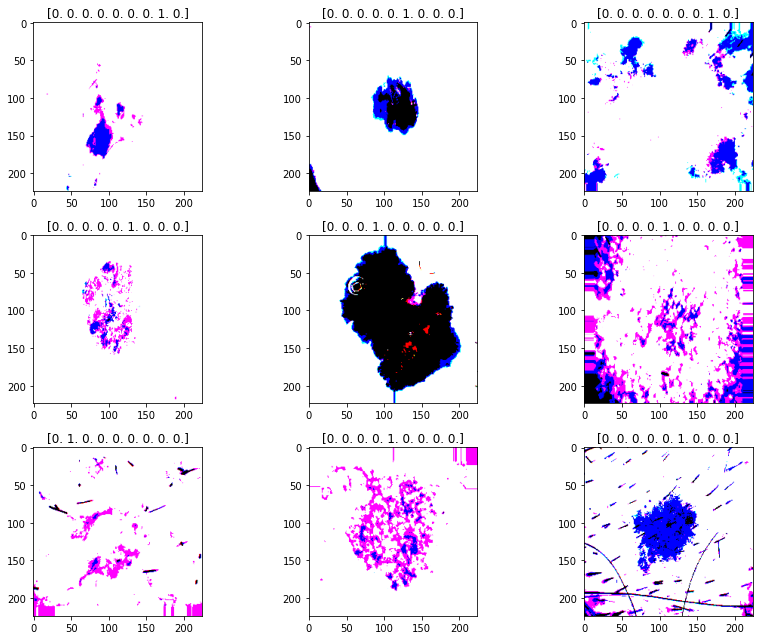

In [14]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

Create and compile the model

# Inecption-V3 Transfer Learning
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [15]:
# count of epchos
EPOCHS = 100

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
import numpy as np

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))
# create the base pre-trained model
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        "accuracy"
    ])

# train the model on the new data for a few epochs
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/100
56/56 [==============================] - 60s 982ms/step - loss: 10.2782 - precision_1: 0.2422 - recall_1: 0.1904 - auc_1: 0.6112 - accuracy: 0.2278 - val_loss: 2.9397 - val_precision_1: 0.2874 - val_recall_1: 0.1585 - val_auc_1: 0.6551 - val_accuracy: 0.2232
Epoch 2/100
56/56 [==============================] - 53s 944ms/step - loss: 2.5199 - precision_1: 0.3202 - recall_1: 0.1547 - auc_1: 0.6962 - accuracy: 0.2719 - val_loss: 2.1105 - val_precision_1: 0.3503 - val_recall_1: 0.1384 - val_auc_1: 0.7364 - val_accuracy: 0.3058
Epoch 3/100
56/56 [==============================] - 53s 953ms/step - loss: 2.1438 - precision_1: 0.3893 - recall_1: 0.1541 - auc_1: 0.7328 - accuracy: 0.3177 - val_loss: 2.3444 - val_precision_1: 0.3251 - val_recall_1: 0.1763 - val_auc_1: 0.7251 - val_accuracy: 0.2902
Epoch 4/100
56/56 [==============================] - 52s 934ms/step - loss: 1.9196 - precision_1: 0.4550 - recall_1: 0.1385 

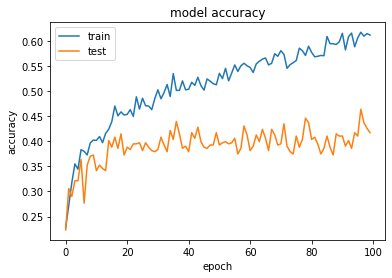

In [20]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_3
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [22]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 249
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        "accuracy"
    ])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/100
56/56 [==============================] - 61s 960ms/step - loss: 2.0707 - precision_2: 0.2130 - recall_2: 0.0257 - auc_2: 0.6881 - accuracy: 0.2278 - val_loss: 1.9534 - val_precision_2: 0.6000 - val_recall_2: 0.0067 - val_auc_2: 0.7250 - val_accuracy: 0.2634
Epoch 2/100
56/56 [==============================] - 52s 931ms/step - loss: 1.9129 - precision_2: 0.5918 - recall_2: 0.0162 - auc_2: 0.7358 - accuracy: 0.2775 - val_loss: 1.9492 - val_precision_2: 0.3333 - val_recall_2: 0.0112 - val_auc_2: 0.7230 - val_accuracy: 0.2232
Epoch 3/100
56/56 [==============================] - 52s 937ms/step - loss: 1.8585 - precision_2: 0.6562 - recall_2: 0.0235 - auc_2: 0.7577 - accuracy: 0.3283 - val_loss: 1.8995 - val_precision_2: 0.4231 - val_recall_2: 0.0246 - val_auc_2: 0.7398 - val_accuracy: 0.2991
Epoch 4/100
56/56 [==============================] - 53s 954ms/step - loss: 1.8177 - precision_2: 0.6522 - recall_2: 0.0251 - auc_2: 0.7727 - accuracy: 0.3484 - val_loss: 1.8487 - val_precis

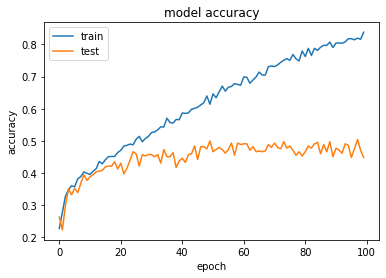

In [23]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Load test data

In [24]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [25]:
X_test.head(3)

,FilePaths,Labels
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


In [26]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


vascular lesion                3
seborrheic keratosis           3
actinic keratosis             16
dermatofibroma                16
pigmented benign keratosis    16
melanoma                      16
squamous cell carcinoma       16
basal cell carcinoma          16
nevus                         16
Name: Labels, dtype: int64

Preprocess test image

In [27]:
# image preprocessing
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Found 118 validated image filenames belonging to 9 classes.


Evaluate model againts test data

In [28]:
res = model.evaluate(X_test)

4/4 [==============================] - 9s 2s/step - loss: 2.6473 - precision_2: 0.2911 - recall_2: 0.1949 - auc_2: 0.7212 - accuracy: 0.2542


The accuracy

In [29]:
# accuracy
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 83.81
Val Accuracy: 44.87
Test Accuracy: 29.11
Train Loss: 51.31
Val Loss: 163.29
Test Loss: 264.73


Calculate y_pred

In [30]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Y_pred (118, 9)
y_pred 118


Calculate y_true

In [31]:
# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred 118
labels 9


The confusion metric

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.ticker import FuncFormatter
import textwrap as tw

[Text(0.5, 0, 'actinic\nkeratosis'),
 Text(1.5, 0, 'basal cell\ncarcinoma'),
 Text(2.5, 0, 'dermatofib\nroma'),
 Text(3.5, 0, 'melanoma'),
 Text(4.5, 0, 'nevus'),
 Text(5.5, 0, 'pigmented\nbenign\nkeratosis'),
 Text(6.5, 0, 'seborrheic\nkeratosis'),
 Text(7.5, 0, 'squamous\ncell\ncarcinoma'),
 Text(8.5, 0, 'vascular\nlesion')]

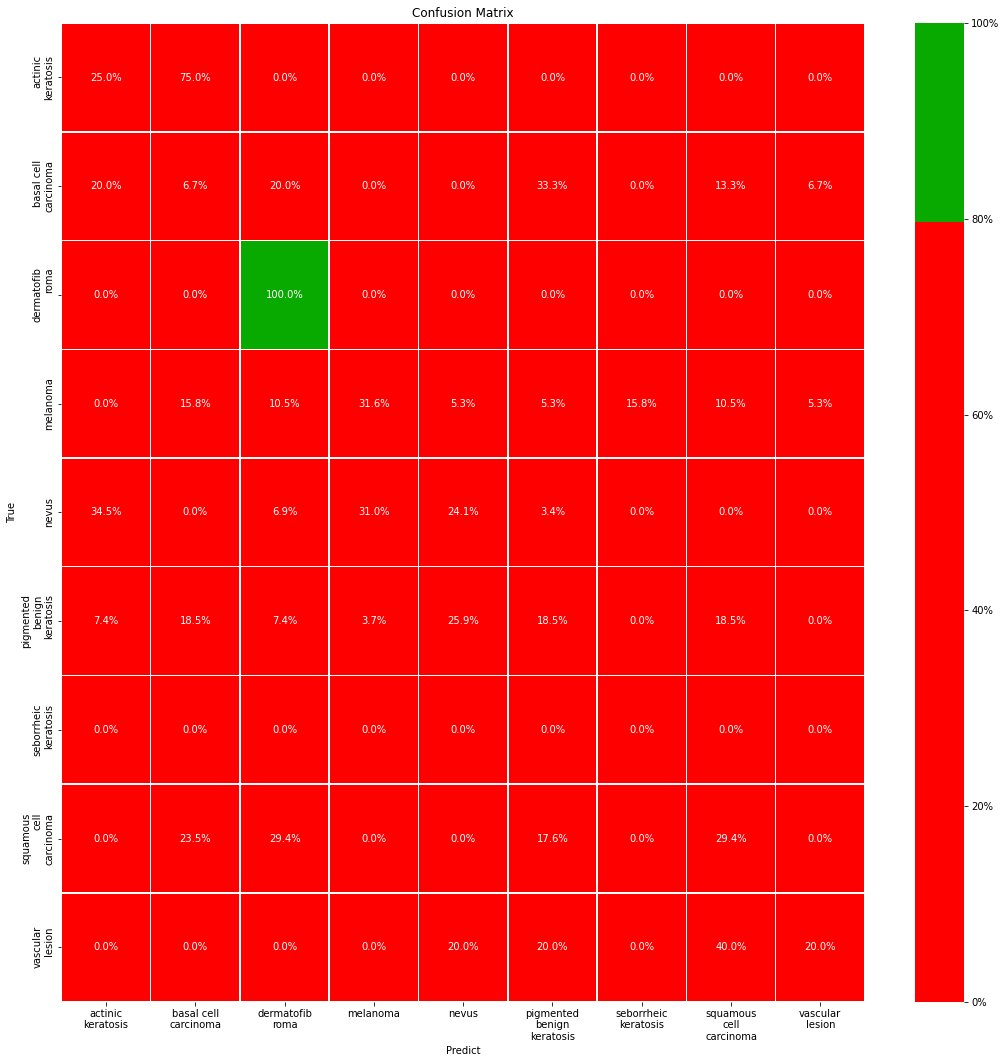

In [33]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(18,18))
# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0000', '#09AA00'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage' 
               linecolor='white',
               ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])